# LDA Model Comparison
This notebook presents a framework for comparing LDA models.

This follows a 4-step process:
1. Load in the two LDA models under investigation.
2. Perform heirarchical clustering among all topics in the two models.
3. Plot the topic alignment.
4. Plot the topic alignment agreement.

## 1. Load the two models

In [1]:
from vsm import *
from ConfigParser import ConfigParser

#函数加载ｃｏｎｆｉｇ文件
def load_from_config(config_file, k):
    
    config = ConfigParser()
    config.read(config_file)

    # path variables
    path = config.get('main', 'path')
    context_type = config.get('main', 'context_type')
    corpus_file = config.get('main', 'corpus_file')
    model_pattern = config.get('main', 'model_pattern') 

    c = Corpus.load(corpus_file)
    m = LdaCgsMulti.load(model_pattern.format(k))
    v = LdaCgsViewer(c, m)
    return v


In [2]:
v1 = load_from_config('/home/hongliang/inpho/handian/compare/handian2and2mac/handiantest.ini', k=20)
v2 = load_from_config('/home/hongliang/inpho/handian/compare/handian2and2mac/handiantest1.ini', k=20)


Running from notebook, using serial load function.
Loading LDA data from /home/hongliang/inpho/handian/compare/handian2and2mac/models/handiantest-freq5-LDA-K20-document-200.npz
Running from notebook, using serial load function.
Loading LDA data from /home/hongliang/inpho/handian/compare/handian2and2mac/models/handiantest-freq5-LDA-K20-document-1000.npz


The following cells are more or less automatically importing everything you need to do the alignment

In [3]:

from vsm import *
import numpy as np
import itertools
import copy
from scipy.stats import spearmanr, rankdata
from scipy.stats import pearsonr

from random import randrange
import random


import os.path
from ConfigParser import ConfigParser



#验证路径合法
def is_valid_filepath(parser, arg):
    if not os.path.exists(arg):
        parser.error("The file %s does not exist!" % arg)
    else:
        return arg
    
# 以列表形式输入一串文章地址，得到ｎｅｗ_corpus类，里面有文本的数据
def deep_subcorpus(labels):
    # resolve labels to indexes
    #　给每个文章一个索引号
    #  v._res_doc_type(d)  (2,u'label')
    # docs_labels ［(0,u'第一个文本')，（１，ｕ＇第二个文本＇），．．．．］
    # docs (1,)   labels (u'文件地址',)
    docs_labels = [v._res_doc_type(d) for d in labels]
    docs, labels = zip(*docs_labels)
    
    # get lengths of all contexts　
    # 所有文本的长度
    lens = np.array([len(ctx) for ctx in v.corpus.view_contexts('document')])
    
    # get the context_type index for use with context_data
    
    ctx_idx = v.corpus.context_types.index(v.model.context_type)
    
    # get original slices 一个超级大的索引数字列表
    slice_idxs = [range(s.start,s.stop) for i, s in enumerate(v.corpus.view_contexts('document',as_slices=True)) 
                      if i in docs]
    
    new_corpus = copy.deepcopy(v.corpus)
    # reduce corpus to subcorpus    
    new_corpus.corpus = new_corpus.corpus[list(itertools.chain(*slice_idxs))]
    
    # reinitialize index fields
    for i,d in enumerate(docs):
        new_corpus.context_data[ctx_idx]['idx'][d] = lens[list(docs[:i+1])].sum()
    
    # reduce metadata to only the new subcorpus
    new_corpus.context_data[ctx_idx] = new_corpus.context_data[ctx_idx][list(docs)]
    
    
    
    return new_corpus


from vsm.spatial import *

import numpy as np
import scipy.cluster.hierarchy as sch
from mpl_toolkits.axes_grid1 import make_axes_locatable


#  模型距离，平均相似度，困惑，模型状态，画图表现主题相似度，对比模型
__all__ = ['model_dist','avg_log_likelihood','perplexity','model_stats','plot_topic_similarity','compare_models']


# 主题覆盖率（Ｋ等于２０之后，两个模型的重复度）
# 返回一个字典里面有一个词典，和两个ｔｏｐｉｃｓ的矩阵.
def topic_overlap(v1,v2):
    """
    Calculates the overlap of two corpora and recalculates normalized topic matricies
    including only the overlapping words, ordered by the overlap order.
    
    Returns the joint vocabulary, v1.topics() and v2.topics() filtered and renormed.
    """
    vocab = set(v1.corpus.words)
    t1 = np.array(v1.topics())['value']
    t2 = np.array(v2.topics())['value']
    
    if v1.corpus.words_int != v2.corpus.words_int:
        print "corpus.words_int different, aligning words"
        vocab = vocab.intersection(v2.corpus.words)
        print "preserving {}% of words in v1; ".format(100 * len(vocab) / float(len(v1.corpus.words))),
        print "{}% of words in v2 ".format(100 * len(vocab) / float(len(v2.corpus.words)))
        
        t1 = t1[:,np.array([v1.corpus.words_int[word] for word in vocab])]
        t1 = (t1.T / t1.sum(axis=1)).T

        t2 = t2[:,np.array([v2.corpus.words_int[word] for word in vocab])]
        t2 = (t2.T / t2.sum(axis=1)).T

    return (vocab, t1, t2)


# k = 20 时候，矩阵　40*40
# k = 40　时候，矩阵８０＊８０
def model_dist(v1,v2, dist_fn=JS_dist):
    """
    Takes two LdaViewer objects and a distance metric and calculates the topic-topic distance.
    """
    vocab, t1, t2 = topic_overlap(v1,v2)
    #t1 = np.array(v1.topics())['value']
    #t2 = np.array(v2.topics())['value']
    combined = np.concatenate((t1,t2))
    
    # NOTE: Doing this by row to reduce memory requirements and time requirements
    D = np.column_stack(np.lib.pad(dist_fn(combined[i:,:],row.T), 
                                   (i,0), 'constant', constant_values=0)
                                if i + 1 < len(combined) else np.zeros(len(combined))
                            for i,row in enumerate(combined))
    return D + D.T - np.diag(D.diagonal())
    # Old simple version:
    # return np.column_stack(dist_fn(combined,row.T) for row in combined)

    
# 返回８5个文本列表，两个20*85维的矩阵，
def doc_overlap(v1,v2, context_type, norm=True):
    context_label = context_type + '_label'
    ids = np.intersect1d(v1.corpus.view_metadata(context_type)[context_label], 
                         v2.corpus.view_metadata(context_type)[context_label])
    d1 = v1.doc_topic_matrix(ids)
    d2 = v2.doc_topic_matrix(ids)

    # renormalize so that each topic is now a document probability
    if norm:
        d1 = (d1 / d1.sum(axis=0))
        d2 = (d2 / d2.sum(axis=0))
    
    # original d1 and d2 are doc_topic, switch to topic_doc
    return (ids, d1.T, d2.T)


#　４０＊４０的矩阵
def model_doc_dist(v1, v2, context_type, dist_fn=JS_dist):
    ids, d1, d2 = doc_overlap(v1,v2, context_type)
    combined = np.concatenate((d1,d2))

    # NOTE: Doing this by row to reduce memory requirements and time requirements
    D = np.column_stack(np.lib.pad(dist_fn(combined[i:,:],row.T),
                                   (i,0), 'constant', constant_values=0)
                                    if i + 1 < len(combined) else np.zeros(len(combined))
                                for i,row in enumerate(combined))
    return D + D.T - np.diag(D.diagonal())


def pearson(v1, v2, context_type):
    context_label = context_type + '_label'
    ids, d1, d2 = doc_overlap(v1, v2, context_type)

    r_all = []
    for id in ids:
        sim1 = v1.dist_doc_doc(id)
        ix = np.in1d(sim1['doc'], ids).reshape(sim1['doc'].shape)
        sim1 = sim1[np.where(ix)]
        sim1 = sim1[sim1['doc'].argsort()]
        
        sim2 = v2.dist_doc_doc(id)
        ix = np.in1d(sim2['doc'], ids).reshape(sim2['doc'].shape)
        sim2 = sim2[np.where(ix)]
        sim2 = sim2[sim2['doc'].argsort()]
        
        r, pval = pearsonr(sim1['value'], sim2['value'])
        r_all.append(r)
    
    return sum(r_all)/len(r_all)

def spearman(v1, v2, context_type):
    context_label = context_type + '_label'
    ids, d1, d2 = doc_overlap(v1, v2, context_type)

    r_all = []
    for id in ids:
        sim1 = v1.dist_doc_doc(id)
        ix = np.in1d(sim1['doc'], ids).reshape(sim1['doc'].shape)
        sim1 = sim1[np.where(ix)]
        sim1 = sim1[sim1['doc'].argsort()]
        
        sim2 = v2.dist_doc_doc(id)
        ix = np.in1d(sim2['doc'], ids).reshape(sim2['doc'].shape)
        sim2 = sim2[np.where(ix)]
        sim2 = sim2[sim2['doc'].argsort()]

        r, pval = spearmanr(rankdata(sim1['value']), rankdata(sim2['value']))
        r_all.append(r)

    return sum(r_all)/len(r_all)

def recall(v1,v2, context_type,N=10):
    context_label = context_type + '_label'
    ids, d1, d2 = doc_overlap(v1, v2, context_type)

    r_all = []
    for id in ids:
        sim1 = v1.dist_doc_doc(id)
        ix = np.in1d(sim1['doc'], ids).reshape(sim1['doc'].shape)
        sim1 = sim1[np.where(ix)]

        sim2 = v2.dist_doc_doc(id)
        ix = np.in1d(sim2['doc'], ids).reshape(sim2['doc'].shape)
        sim2 = sim2[np.where(ix)]

        sim1 = np.array(sim1[1:N+2])['doc']
        sim2 = np.array(sim2[1:N+2])['doc']
        r = np.where(np.in1d(sim1, sim2))[0].size / float(N)
        r_all.append(r)
    
    return sum(r_all)/len(r_all)

def avg_log_likelihood(viewer):
    """ Calculates the average log likelihood per token. """
    return viewer.model.log_probs[-1][1] / len(viewer.corpus.corpus)

def perplexity(viewer):
    """ Calculates the perplexity. """
    return np.exp(-1*avg_log_likelihood(viewer))

def model_stats(*viewers):
    """
    Prints a table of avg log likelihood and perplexity for each viewer.
    """
    print "model", "k", "tokens", "types", "avg-log-likelihood", "perplexity"
    for i,v in enumerate(viewers):
        print "M{}".format(i), v.model.K, len(v.corpus.corpus), len(v.corpus.words), avg_log_likelihood(v), perplexity(v)

## 2. Cluster Functions

In [4]:
%pylab inline
from mpl_toolkits.axes_grid1 import make_axes_locatable

import scipy
import scipy.cluster.hierarchy as sch

def create_dendogram(D, xdim=None, method='ward', show=True):
    # create_dendogram
    fig = pylab.figure(figsize=(3,9))
    Y = sch.linkage(D, method=method)
    Z = sch.dendrogram(Y, orientation='right')
    
    # create plot
    if show:
        ax = fig.gca()
        ax.set_xticks([])
        if xdim is not None:
            ax.set_yticklabels(["M2 " + str(idx - xdim) if idx >= xdim else "M1 " + str(idx)
                                for idx in np.array(Z['leaves'])])
        fig.show()
    else:
        pylab.close()
    return Z

import pylab
def plot_dendogram(D, Z, xdim,ydim, filter_axis=False, show_self=False):
    # Compute and plot dendrogram.
    fig = pylab.figure(figsize=(12,10))
    
    D = np.copy(D)
    
    # Now make plot better
    if not show_self:
        D[:xdim,:xdim] = 0
        D[xdim:,xdim:] = 0

    # Plot distance matrix.
    axmatrix = fig.add_axes([0.3,0.1,0.6,0.8])
    index = np.array(Z['leaves'])
    if filter_axis:
        D = D[index[index < xdim],:]
        D = D[:,index[index >= xdim]]
    else:
        D = D[index,:]
        D = D[:,index]
    im = axmatrix.imshow(D, interpolation='none', cmap=mpl.cm.Greys_r, vmax=0.25, vmin=0.0)#aspect='auto', origin='lower')
    if filter_axis:
        axmatrix.set_xticks(arange(ydim))
        axmatrix.set_xticklabels([str(i -xdim) for i in index[index >= xdim]])
        axmatrix.set_yticks(arange(xdim))
        axmatrix.set_yticklabels([str(i) for i in index[index < xdim]])
    else:
        axmatrix.set_xticks(arange(xdim+ydim))
        axmatrix.set_xticklabels(index)
        axmatrix.set_yticks(arange(xdim+ydim))
        axmatrix.set_yticklabels(index)
    
    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    divider = make_axes_locatable(axmatrix)
    cax = divider.append_axes("right", size="5%", pad=0.15)

    fig.colorbar(im, cax=cax)

    # Display and save figure.
    fig.show()


def plot_dendogram(D, Z, xdim,ydim, dist=None, filter_axis=False, show_self=False, alignment=None):
    # Compute and plot dendrogram.
    fig = figure(figsize=(12,10))
    
    D = np.copy(D)
    
    # Now make plot better
    if not show_self:
        D[:xdim,:xdim] = 0
        D[xdim:,xdim:] = 0

    # Plot distance matrix.
    axmatrix = fig.add_axes([0.3,0.1,0.6,0.8])
    index = np.array(Z['leaves'])
    if filter_axis:
        D = D[index[index < xdim],:]
        D = D[:,index[index >= xdim]]
    else:
        D = D[index,:]
        D = D[:,index]
        
    # generate palette
    palette=cm.Blues_r
    palette.set_bad(alpha=0.0)
    MAX = np.sort(D.flatten())[int(.1*D.shape[0]*D.shape[1])]
    MAX = np.max(np.diagonal(dist[:,dist.argsort(axis=0)[1]]))
    MAX *= 1.1
    im = axmatrix.imshow(D, interpolation='none', cmap=palette, vmax=MAX, vmin=0.0)#aspect='auto', origin='lower')
    if filter_axis:
        axmatrix.set_xticks(arange(ydim))
        axmatrix.set_xticklabels([str(i - xdim) for i in index[index >= xdim]])
        axmatrix.set_yticks(arange(xdim))
        axmatrix.set_yticklabels([str(i) for i in index[index < xdim]])
    else:
        axmatrix.set_xticks(arange(xdim+ydim))
        axmatrix.set_xticklabels(index)
        axmatrix.set_yticks(arange(xdim+ydim))
        axmatrix.set_yticklabels(index)
    
    if alignment is not None:
        axmatrix.autoscale(False)
        ys,xs = zip(*alignment)
        xindex = index[index >= xdim] - xdim
        yindex = index[index < xdim]
        
        xs = np.array([np.squeeze(np.where(xindex == x)) for x in xs])
        ys = np.array([np.squeeze(np.where(yindex == y)) for y in ys])
        
        axmatrix.scatter(xs, ys, marker='o', s=125, color='w', lw=4, edgecolor='k')
    
    title("Jensen-Shannon Distance from topic to topic")
    ylabel("Model 1")
    xlabel("Model 2")
    # Plot colorbar.
    #axcolor = fig.add_axes([0.91,0.1,0.02,0.8])
    divider = make_axes_locatable(axmatrix)
    cax = divider.append_axes("right", size="3%", pad=0.1)
    colorbar(im, cax=cax, extend='max')

def dendogram_demo():
    # Generate features and distance matrix.
    x = scipy.rand(40)
    D = scipy.zeros([40,40])
    for i in range(40):
        for j in range(40):
            D[i,j] = abs(x[i] - x[j])
    

    gram = create_dendogram(D, show=False)
    #dendo = plot_dendogram(D,gram,10,30, show_self=True)
    dendo = plot_dendogram(D,gram,10,30, D, show_self=False)
    #dendo = plot_dendogram(D,gram,10,30, show_self=True, filter_axis=True)
    dendo = plot_dendogram(D,gram,10,30, D, show_self=False, filter_axis=True)

Populating the interactive namespace from numpy and matplotlib


/home/hongliang/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random', 'copy', '__version__', 'angle']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [5]:
## Model comparison code

def plot_topic_similarity(v1, v2, dist=None, dist_fn=JS_dist, sorted=True, alignment=None):
    # Calculate distance between all topics
    if dist is None:
        dist = model_dist(v1, v2, dist_fn)
    # print dist

    if sorted:
        dendo = create_dendogram(dist, xdim=v1.model.K, method='ward') 
        plot_dendogram(dist, dendo, v1.model.K, v2.model.K, dist=dist, filter_axis=True, alignment=alignment)
    else:
        # plot distance heatmap
        figure(figsize=(12,10))
        
        # filtering axis
        xdim = v1.model.K
        index = np.arange(0,len(dist))
        D = np.copy(dist)
        D = D[index[index < xdim],:]
        D = D[:,index[index >= xdim]]
        
        # generate palette
        palette=cm.Blues_r
        palette.set_bad(alpha=0.0)
        MAX = np.sort(D.flatten())[int(.1*D.shape[0]*D.shape[1])]
        MAX = np.max(np.diagonal(dist[:,dist.argsort(axis=0)[1]]))
        MAX *= 1.1
        
        # plot data
        im = imshow(D, cmap=palette, vmax=MAX, vmin=0.0, interpolation='none')
        if alignment is not None:
            ax = gca()
            ax.autoscale(False)
            ys,xs = zip(*alignment)
            scatter(xs,ys, marker='x', s=200, color='w', lw=5)
            print xs,ys
            
        
        # label data
        xticks(np.arange(D.shape[1]))
        yticks(np.arange(D.shape[0]))
        title("Jensen-Shannon Distance from topic to topic")
        xlabel("Model 1")
        ylabel("Model 2")
        
        # create heatmap
        divider = make_axes_locatable(gca())
        cax = divider.append_axes("right", size="3%", pad=0.1)
        colorbar(im, cax=cax, extend='max')

def compare_models(v1, v2, context_type='document', dist_fn=JS_dist, sorted=True):
    model_stats(v1,v2)
    plot_topic_similarity(v1,v2,dist_fn=dist_fn,sorted=sorted)

## 3. Create asymmetric model comparison matrix

In [6]:
print(dist)

<function dist at 0x7f660cde35f0>


In [7]:

def alignment_fitness(topic_pairs, v1, v2, dist=None, dist_fn=JS_dist):
    """
    Takes a list of topic pair tuples and returns the sum of the JS_dist between them
    """    
    if dist is None:
        dist = model_dist(v1, v2, dist_fn)
    if dist.shape[0] == (v1.model.K + v2.model.K):
        dist = filter_dist(v1, v2, dist)
    
    return sum([dist[t[0]][t[1]] for t in topic_pairs])

def filter_dist(v1,v2,dist):
    xdim = v1.model.K
    index = np.arange(0,len(dist))
    D = np.copy(dist)
    D = D[index[index < xdim],:]
    D = D[:,index[index >= xdim]]
    return D

def plot_alignment(v1, v2, dist, alignment=None, fn_name=None):
    # Calculate distance between all topics
    if dist is None:
        dist = model_dist(v1, v2, dist_fn)
    if dist.shape[0] == (v1.model.K + v2.model.K):
        dist = filter_dist(v1, v2, dist)
    
    Xs = cm.jet_r(dist)
    
    if alignment is None:
        alpha = 1.0
    else:
        alpha = np.zeros(dist.shape)
        alpha[zip(*alignment)] = 1
    
    Xs[:,:,3] = alpha
    
    # plot distance heatmap
    figure(figsize=(12,10))
    imshow(Xs, interpolation='nearest', cmap='jet_r', vmin=0, vmax=1.0)
    colorbar()
    #imshow(alpha, interpolation=None, cmap=get_cmap('binary'), vmin=0, vmax=1.0, alpha=0.5)
    xticks(np.arange(dist.shape[1]))
    yticks(np.arange(dist.shape[0]))
    
    if fn_name is not None:
        title("Topic Alignment %s() using Jensen-Shannon Distance" % fn_name)
    else:
        title("Topic Alignment")
    xlabel("Model 1")
    ylabel("Model 2")
    show()


# In[46]:

def basic_alignment(v1, v2, dist=None, dist_fn=JS_dist, debug=False):
    """
    Simply aligns to the closest topic, allowing for multiple assignment. 
    Properties:
        non-surjective, non-injective
    """
    if dist is None:
        dist = model_dist(v1, v2, dist_fn)
    if dist.shape[0] == (v1.model.K + v2.model.K):
        dist = filter_dist(v1, v2, dist)
        
    alignment = []
    for i, topic in enumerate(dist):
        # topic = a[i]
        #s = topic[topic.argsort()]
        #sim = topic.argsort()[s < 0.05]
        closest = topic.argsort()[0]
        alignment.append((i, closest))
        if debug:
            print i, closest, topic[closest]
    
    return alignment


# In[47]:

def naive_alignment(v1, v2, dist=None, dist_fn=JS_dist, debug=False):
    """
    First naive overlap detector just goes to next closest element if the first topic has already been assigned
    
    Properties: 
        k1 < k2: injective, non-surjective
        k1 == k2: bijective
    """
    if v1.model.K > v2.model.K:
        raise ValueError("Models must have k1 <= k2")
    if dist is None:
        dist = model_dist(v1, v2, dist_fn)
    if dist.shape[0] == (v1.model.K + v2.model.K):
        dist = filter_dist(v1, v2, dist)
    
    alignment = []
    aligned = []
    for i, topic in enumerate(dist):
        # topic = a[i]
        #s = topic[topic.argsort()]
        #sim = topic.argsort()[s < 0.05]
        topic_idx = 0
        closest = topic.argsort()[topic_idx]
        if debug:
            print i, closest, topic[closest]
        
        while closest in aligned:
            topic_idx += 1
            closest = topic.argsort()[topic_idx]
            if debug:
                print i, closest, topic[closest]
        
        
        aligned.append(closest)
        alignment.append((i, closest))
    
    print alignment
    return alignment

def compare(sample_v, v):
    sample_size = len(sample_v.labels)

    print "{k}\t{N}\t{seed}\t{LL}\t{corpus_size}\t".format(k=sample_v.model.K, 
        N=sample_size, seed=sample_v.model.seed, 
        LL=sample_v.model.log_probs[-1][1],
        corpus_size=len(sample_v.corpus)),

    # compute similarity on topic-word matrix - given a topic, what is its
    # distribution over words?
    dist = model_dist(sample_v, v)
    basic = basic_alignment(sample_v, v, dist=dist)
    naive = naive_alignment(sample_v, v, dist=dist)
    m1, m2 = zip(*basic)
    
    print "{fitness}\t{naive_fitness}\t{overlap}\t".format(
        fitness=alignment_fitness(basic, sample_v, v, dist=dist),
        naive_fitness=alignment_fitness(naive, sample_v, v, dist=dist),
        overlap=len(set(m2))),

    # Compute similarity on topic-document matrix - given a topic, what is its
    # distribution over documents?
    dist = model_doc_dist(sample_v, v, 'document')
    basic = basic_alignment(sample_v, v, dist=dist)
    naive = naive_alignment(sample_v, v, dist=dist)
    m1, m2 = zip(*basic)
    
    print "{fitness}\t{naive_fitness}\t{overlap}\t".format(
        fitness=alignment_fitness(basic, sample_v, v, dist=dist),
        naive_fitness=alignment_fitness(naive, sample_v, v, dist=dist),
        overlap=len(set(m2))),

    # Calculate Spearman, Pearson, top-10 recall, and top-10-percent recall
    # for each document - more of an IR-related search
    print "{spearman}\t{pearson}\t{recall}\t{recall10p}".format(
        spearman=spearman(sample_v, v,'document'),
        pearson=pearson(sample_v, v, 'document'),
        recall=recall(sample_v, v, 'document', N=10),
        recall10p=recall(sample_v,v,'document', N=int(np.floor(0.1*sample_size))))

## 4. Model Comparison

Running from notebook, using serial load function.
Loading LDA data from /home/hongliang/inpho/handian/compare/handian2and2mac/models/handiantest-freq5-LDA-K20-document-200.npz
Running from notebook, using serial load function.
Loading LDA data from /home/hongliang/inpho/handian/compare/handian2and2mac/models/handiantest-freq5-LDA-K20-document-1000.npz
model k tokens types avg-log-likelihood perplexity
M0 20 209578 1934 -6.17896797374 482.493753093
M1 20 209578 1934 -6.22212195459 503.771078013


/home/hongliang/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


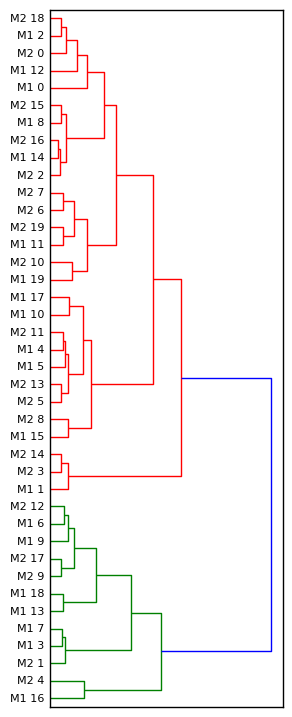

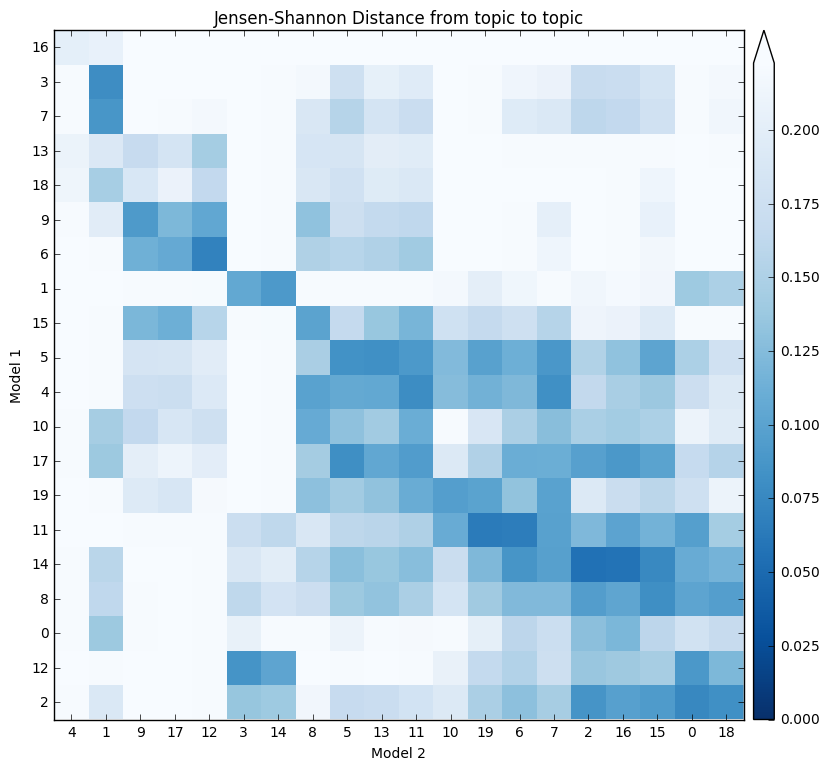

In [8]:
v1 = load_from_config('/home/hongliang/inpho/handian/compare/handian2and2mac/handiantest.ini', k=20)
v2 = load_from_config('/home/hongliang/inpho/handian/compare/handian2and2mac/handiantest1.ini', k=20)
# prints statistical comparisons
compare_models(v1,v2)



In [9]:
 # 1. 13 is best 
#    4 is 
#    9 to 14
#    they are have best match , then 100%
#2. 13 is not, goes
#    4 is 
#    9 is 14, 10
#    score 2/3 have best fit .  66.6666%
#    overlap 是ｔｏｐｉｃ的．全都是ｂｅｓｔ　ｆｉｔ　．　Ｈｉｇｈｅｒ　ｉｓ better. 

   

# renders chart comparing two models.
compare(v1,v2)


20	85	1198981842	-1294975.75	209578	[(0, 16), (1, 14), (2, 0), (3, 1), (4, 11), (5, 13), (6, 12), (7, 5), (8, 15), (9, 9), (10, 8), (11, 19), (12, 3), (13, 17), (14, 2), (15, 7), (16, 4), (17, 6), (18, 18), (19, 10)]
1.94676539764	2.25774094891	16	[(0, 16), (1, 0), (2, 18), (3, 2), (4, 8), (5, 5), (6, 12), (7, 15), (8, 13), (9, 10), (10, 7), (11, 6), (12, 3), (13, 1), (14, 14), (15, 17), (16, 11), (17, 19), (18, 4), (19, 9)]
7.38885643972	9.75611028157	14	0.843386635092	0.928836227763	0.772941176471	0.75


# Interpretaiton Notes
A perfect alignment between two models would show a dark diagonal all the way down the alignment heatmap.

If multiple cells for a particular row or column are dark, this indicates that the topic is captured by multiple topics in the other model.

Note that often missing data is as illuminating as the presence of data in a model alignment: if a particular row or column is entirely white, then that indicates that it is not covered in the other model at all. When looking at data aggregated by year from a particular discipline, this may indicate the introduction or removal of a particular topic from discussion.

In [10]:
# -*- coding:UTF-8 -*-
import sys
reload(sys)
sys.setdefaultencoding( "utf-8" )
# viewing particular topics in each model
print v1.topics([16])
print v2.topics([2])

In [11]:
set1 = []
for a in basic_alignment(v1,v2):
    set1.append(a[1])
k = float(20)
len(set(set1))/k

0.8

0.8